<a href="https://colab.research.google.com/github/ven7sg/DS-3001-project-voting/blob/main/Project3_model%26VIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/ven7sg/DS-3001-project-voting.git

fatal: destination path 'DS-3001-project-voting' already exists and is not an empty directory.


In [ ]:
#!rm -r DS-3001-project-voting

In [ ]:
!pip3 install mapclassify

In [ ]:
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gdf = gpd.read_file('/content/drive/My Drive/Colab Notebooks/va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
cdf = pd.read_csv('/content/DS-3001-project-voting/cleaned data/county_final.csv') # Load county adjacency data and population data
vdf = pd.read_csv('/content/DS-3001-project-voting/cleaned data/voting_final.csv') # Load historical voting data
merged = pd.read_csv('/content/DS-3001-project-voting/cleaned data/merged_final.csv') #merged cdf and vdf

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='county_fips')  # merge county population and adjacency data into df


In [ ]:
nhgis_county_data=gpd.read_file('/content/DS-3001-project-voting/data/0002_ds250_20205_county_E.csv')
nhgis_county_data

,field_1,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,...,AM8FE032,AM8FE033,AM8FE034,AM8FE035,AM8FE036,AM8FE037,AM8FE038,AM8FE039,AM9SE001,geometry
0,1,GIS Join Match Code,Data File Year,State Postal Abbreviation,Region Code,Division Code,State Name,State Code,County Name,County Code,...,Female: 35 to 64 years: With a disability,Female: 35 to 64 years: No disability,Female: 65 to 74 years,Female: 65 to 74 years: With a disability,Female: 65 to 74 years: No disability,Female: 75 years and over,Female: 75 years and over: With a disability,Female: 75 years and over: No disability,Gini Index,None
1,2,G0100010,2016-2020,AL,,,Alabama,01,Autauga County,001,...,2064,9259,2741,898,1843,1962,1255,707,0.4552,None
2,3,G0100030,2016-2020,AL,,,Alabama,01,Baldwin County,003,...,5851,39064,14209,2921,11288,9539,4370,5169,0.4566,None
3,4,G0100050,2016-2020,AL,,,Alabama,01,Barbour County,005,...,859,3384,1554,436,1118,1074,709,365,0.5047,None
4,5,G0100070,2016-2020,AL,,,Alabama,01,Bibb County,007,...,656,3561,1098,235,863,871,433,438,0.4500,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,3218,G7201450,2016-2020,PR,,,Puerto Rico,72,Vega Baja Municipio,145,...,2511,8020,3059,1350,1709,2644,1570,1074,0.4942,None
3218,3219,G7201470,2016-2020,PR,,,Puerto Rico,72,Vieques Municipio,147,...,82,1578,525,28,497,466,219,247,0.4471,None
3219,3220,G7201490,2016-2020,PR,,,Puerto Rico,72,Villalba Municipio,149,...,1160,3301,1264,656,608,853,596,257,0.5419,None
3220,3221,G7201510,2016-2020,PR,,,Puerto Rico,72,Yabucoa Municipio,151,...,566,6229,2079,517,1562,1636,789,847,0.4987,None


## clean nhgis data 2020

In [ ]:
#nhgis county data cleaning (Carol Wu)
virginia_data = nhgis_county_data[nhgis_county_data['STATE'] == 'Virginia']

#remove YEAR STUSAB REGIONA DIVISIONA STATE STATEA (all VA 2016-2020)
for col in virginia_data.columns:
    if len(virginia_data[col].unique()) == 1:
        virginia_data.drop(col,inplace=True,axis=1)
#select nativity, poverty status by sex, gini index of income ineuqality col
VAcounty_data = virginia_data[['COUNTY','AM0KE002','AM0KE003','AM0KE004','AM0KE005','AM0KE006','AM63E003','AM63E017','AM63E032','AM63E046','AM9SE001']]

In [57]:
column_mapping = {
    'COUNTY' : 'county',
    'AM0KE002': 'U.S. citizen, born in the United States',
    'AM0KE003': 'U.S. citizen, born in Puerto Rico or U.S. Island Areas',
    'AM0KE004': 'U.S. citizen, born abroad of American parent(s)',
    'AM0KE005': 'U.S. citizen by naturalization',
    'AM0KE006': 'Not a U.S. citizen',
    'AM63E003': 'Income in the past 12 months below poverty level: Male',
    'AM63E017': 'Income in the past 12 months below poverty level: Female',
    'AM63E032': 'Income in the past 12 months at or above poverty level: Male',
    'AM63E046':  'Income in the past 12 months at or above poverty level: Female',
    'AM9SE001':   'Gini Index'
}

# Rename the columns
VAcounty_data = VAcounty_data.rename(columns=column_mapping)

In [ ]:
cols_to_convert = VAcounty_data.columns.difference(['county'])
VAcounty_data[cols_to_convert] = VAcounty_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

VAcounty_data

## Kernel Density nhgis 2020 data

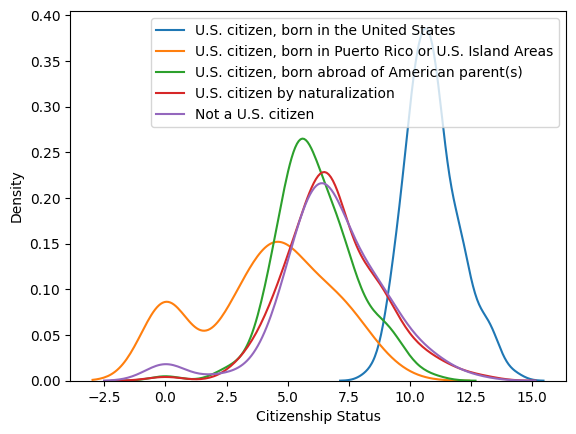

In [ ]:
import seaborn as sns
numeric_vars = ['U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'U.S. citizen, born abroad of American parent(s)', 'U.S. citizen by naturalization', 'Not a U.S. citizen']
for column in numeric_vars:
    VAcounty_data[column] = np.arcsinh(VAcounty_data[column])
    sns.kdeplot(VAcounty_data[column], label=column)
plt.xlabel('Citizenship Status')
plt.legend()
plt.show()




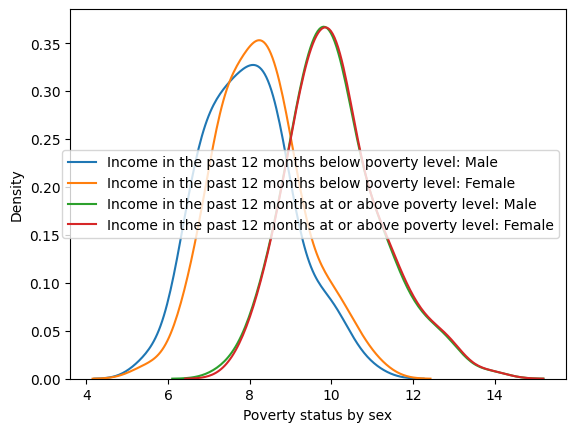

In [ ]:
numeric_vars = ['Income in the past 12 months below poverty level: Male', 'Income in the past 12 months below poverty level: Female', 'Income in the past 12 months at or above poverty level: Male', 'Income in the past 12 months at or above poverty level: Female']
for column in numeric_vars:
    VAcounty_data[column] = np.arcsinh(VAcounty_data[column])
    sns.kdeplot(VAcounty_data[column], label=column)
plt.xlabel('Poverty status by sex')
plt.legend()
plt.show()


<Axes: xlabel='Gini Index', ylabel='Density'>

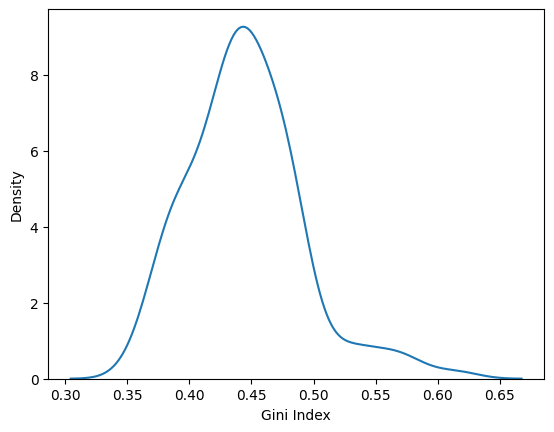

In [ ]:

sns.kdeplot(VAcounty_data['Gini Index'], label=column)

In [ ]:
vdf20 = vdf.loc[ vdf['year']==2020,:] # Only the 2020 data
Dvotes = vdf20.loc[(vdf20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
Dvotes = Dvotes.rename('dem_votes_2020')
Rvotes = vdf20.loc[(vdf20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
Rvotes = Rvotes.rename('rep_votes_2020')

Dvotes_index = Dvotes.index
FIP = Dvotes_index.tolist()
print(FIP)
VAcounty_data['county_fips'] = FIP
VAcounty_data = VAcounty_data.merge(Dvotes,left_on='county_fips',right_on='county_fips') #for mapping
VAcounty_data = VAcounty_data.merge(Rvotes,left_on='county_fips',right_on='county_fips') #for mapping

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]


In [62]:
VAcounty_data

,county,"U.S. citizen, born in the United States","U.S. citizen, born in Puerto Rico or U.S. Island Areas","U.S. citizen, born abroad of American parent(s)",U.S. citizen by naturalization,Not a U.S. citizen,Income in the past 12 months below poverty level: Male,Income in the past 12 months below poverty level: Female,Income in the past 12 months at or above poverty level: Male,Income in the past 12 months at or above poverty level: Female,Gini Index,county_fips,dem_votes_2020,rep_votes_2020,net_vote_count
0,Accomack County,29524,119,192,782,1943,3092,3281,12623,13231,0.4562,51001,7578,9172,8.067149
1,Albemarle County,95653,469,1470,5183,6044,3404,4349,44538,48856,0.4719,51003,42466,20804,-10.676462
2,Alleghany County,14733,0,111,91,95,965,1350,6272,6157,0.4537,51005,2243,5859,8.886271
3,Amelia County,12694,0,97,73,106,695,687,5822,5669,0.4320,51007,2411,5390,8.692490
4,Amherst County,30977,71,151,361,222,1685,1708,13478,14131,0.4239,51009,5672,11041,9.281544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Suffolk city,86063,436,1373,1970,1541,3425,4905,40504,41975,0.4463,51800,28676,20082,-9.751967
129,Virginia Beach city,394661,4085,8526,27552,16058,13645,18072,200829,208107,0.4296,51810,117393,105087,-10.110989
130,Waynesboro city,20936,33,299,325,707,1513,1760,9252,9514,0.4817,51820,4961,5507,6.995767
131,Williamsburg city,13494,30,269,434,807,815,789,4389,4537,0.5440,51830,4790,1963,-8.640119


In [61]:
VAcounty_data['net_vote_count'] = VAcounty_data['rep_votes_2020']-VAcounty_data['dem_votes_2020']
VAcounty_data['net_vote_count'] = np.arcsinh(VAcounty_data['net_vote_count'])

<Axes: xlabel='net_vote_count', ylabel='Density'>

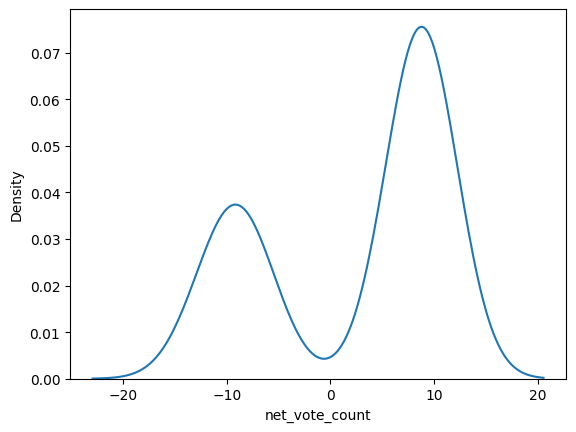

In [ ]:
sns.kdeplot(VAcounty_data['net_vote_count'], label=column)

## clean NHGIS 2022 data

In [ ]:
# clean 2022 data
nhgis_2022 = gpd.read_file('/content/DS-3001-project-voting/data/nhgis0001_ds261_2022_county.csv')
nhgis_2022

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,APYUM052,APYUM053,APYUM054,APYUM055,APYUM056,APYUM057,APYUM058,APYUM059,AP38M001,geometry
0,G0100030,2022,AL,,,Alabama,01,Baldwin County,003,,...,661,1093,990,1042,1139,1361,914,989,0.0244,None
1,G0100150,2022,AL,,,Alabama,01,Calhoun County,015,,...,452,923,907,709,1003,577,764,463,0.0354,None
2,G0100430,2022,AL,,,Alabama,01,Cullman County,043,,...,459,532,640,588,720,576,258,479,0.0428,None
3,G0100490,2022,AL,,,Alabama,01,DeKalb County,049,,...,332,467,557,735,428,637,402,501,0.0265,None
4,G0100510,2022,AL,,,Alabama,01,Elmore County,051,,...,351,362,676,579,545,527,397,278,0.0287,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,G7201130,2022,PR,,,Puerto Rico,72,Ponce Municipio,113,,...,305,660,863,663,702,776,906,697,0.0264,None
844,G7201270,2022,PR,,,Puerto Rico,72,San Juan Municipio,127,,...,730,1355,1450,1309,1442,1429,1298,1448,0.0241,None
845,G7201350,2022,PR,,,Puerto Rico,72,Toa Alta Municipio,135,,...,547,459,671,538,376,373,468,345,0.0316,None
846,G7201370,2022,PR,,,Puerto Rico,72,Toa Baja Municipio,137,,...,444,413,695,721,467,548,469,548,0.0280,None


In [ ]:
VA_2022 = nhgis_2022[nhgis_2022['STATE'] == 'Virginia']

#remove YEAR STUSAB REGIONA DIVISIONA STATE STATEA (all VA 2016-2020)
for col in VA_2022.columns:
    if len(VA_2022[col].unique()) == 1:
        VA_2022.drop(col,inplace=True,axis=1)
#select nativity, poverty status by sex, gini index of income ineuqality col
VAcounty_data_2022 = VA_2022[['COUNTY','APLBE002','APLBE003','APLBE004','APLBE005','APLBE006','APYUE003','APYUE017','APYUE032','APYUE046','AP38E001']]

<ipython-input-19-b872a8edc945>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VA_2022.drop(col,inplace=True,axis=1)
<ipython-input-19-b872a8edc945>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VA_2022.drop(col,inplace=True,axis=1)
<ipython-input-19-b872a8edc945>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VA_2022.drop(col,inplace=True,axis=1)
<ipython-input-19-b872a8edc945>:6: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
column_mapping = {
    'COUNTY' : 'county',
    'APLBE002': 'U.S. citizen, born in the United States',
    'APLBE003': 'U.S. citizen, born in Puerto Rico or U.S. Island Areas',
    'APLBE004': 'U.S. citizen, born abroad of American parent(s)',
    'APLBE005': 'U.S. citizen by naturalization',
    'APLBE006': 'Not a U.S. citizen',
    'APYUE003': 'Income in the past 12 months below poverty level: Male',
    'APYUE017': 'Income in the past 12 months below poverty level: Female',
    'APYUE032': 'Income in the past 12 months at or above poverty level: Male',
    'APYUE046':  'Income in the past 12 months at or above poverty level: Female',
    'AP38E001':   'Gini Index'
}

# Rename the columns
VAcounty_data_2022 = VAcounty_data_2022.rename(columns=column_mapping)

In [ ]:
cols_to_convert = VAcounty_data_2022.columns.difference(['county'])
VAcounty_data_2022[cols_to_convert] = VAcounty_data_2022[cols_to_convert].apply(pd.to_numeric, errors='coerce')

VAcounty_data_2022_X = VAcounty_data_2022[cols_to_convert]

## Kernel Density plot of 2022 NHGIS data

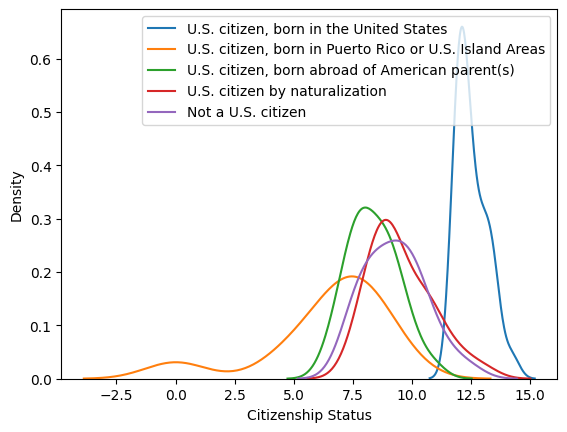

In [ ]:

numeric_vars = ['U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'U.S. citizen, born abroad of American parent(s)', 'U.S. citizen by naturalization', 'Not a U.S. citizen']
for column in numeric_vars:
    VAcounty_data_2022[column] = np.arcsinh(VAcounty_data_2022[column])
    sns.kdeplot(VAcounty_data_2022[column], label=column)
plt.xlabel('Citizenship Status')
plt.legend()
plt.show()


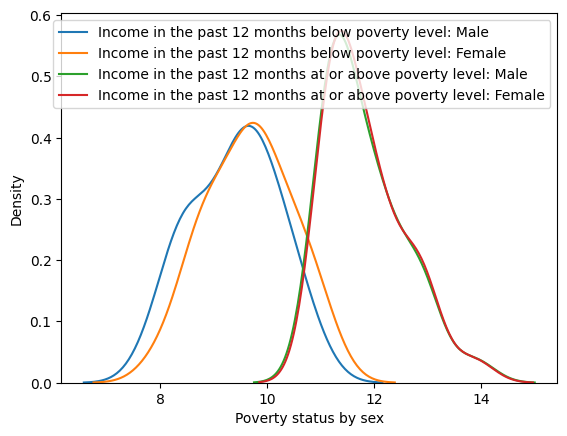

In [ ]:
numeric_vars = ['Income in the past 12 months below poverty level: Male', 'Income in the past 12 months below poverty level: Female', 'Income in the past 12 months at or above poverty level: Male', 'Income in the past 12 months at or above poverty level: Female']
for column in numeric_vars:
    VAcounty_data_2022[column] = np.arcsinh(VAcounty_data_2022[column])
    sns.kdeplot(VAcounty_data_2022[column], label=column)
plt.xlabel('Poverty status by sex')
plt.legend()
plt.show()

<Axes: xlabel='Gini Index', ylabel='Density'>

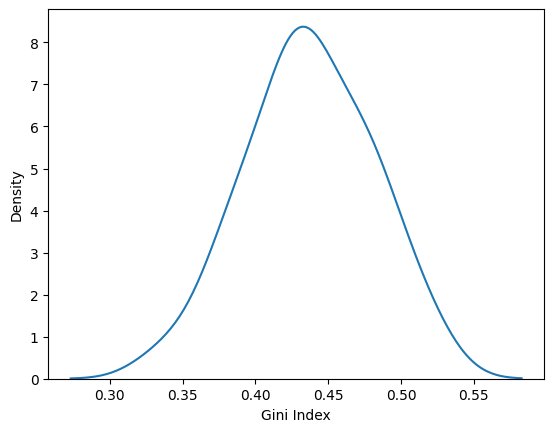

In [ ]:
sns.kdeplot(VAcounty_data_2022['Gini Index'], label=column)

## regression model

Training RMSE: 5.747287444127889 R-squared: 0.583669016436785
Testing RMSE: 7.778432367842413 R-squared: -0.1416368633930496


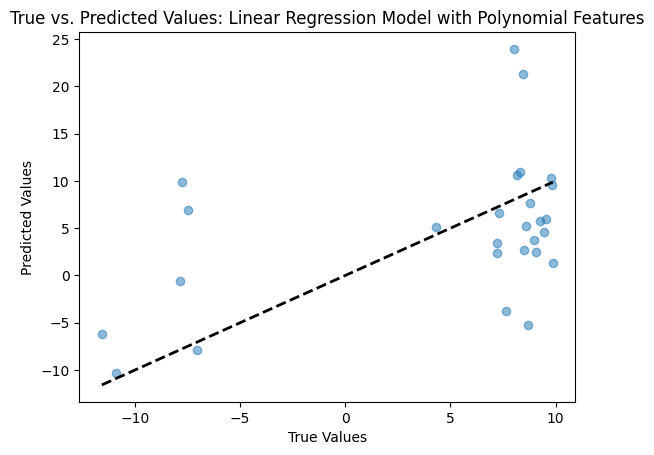

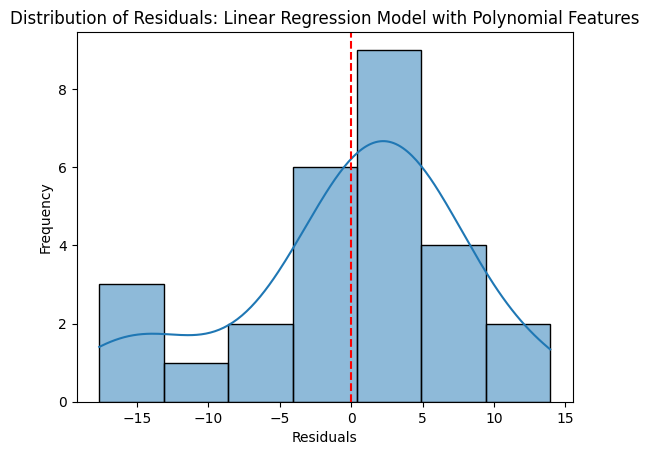

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming VAcounty_data is your DataFrame
# Replace 'dependent_variable_column_name' with the name of your dependent variable column
dependent_variable = 'net_vote_count'

# Variables to include in the model
numeric_vars = ['U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'U.S. citizen, born abroad of American parent(s)', 'U.S. citizen by naturalization', 'Not a U.S. citizen', 'Income in the past 12 months below poverty level: Male', 'Income in the past 12 months below poverty level: Female', 'Income in the past 12 months at or above poverty level: Male', 'Income in the past 12 months at or above poverty level: Female', 'Gini Index']

# Cast to numeric value
for var in numeric_vars:
    VAcounty_data[var] = pd.to_numeric(VAcounty_data[var], errors='coerce')


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(VAcounty_data[numeric_vars], VAcounty_data[dependent_variable], test_size=0.2, random_state=42)

# Linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predictions
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

# RMSE and R-squared for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print('Training RMSE:', train_rmse, 'R-squared:', train_r2)
print('Testing RMSE:', test_rmse, 'R-squared:', test_r2)

# Scatter plot for true vs. predicted values
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values: Linear Regression Model with Polynomial Features')
plt.show()

# Residuals plot
residuals = y_test - y_test_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals: Linear Regression Model with Polynomial Features')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [ ]:
y_pred_numeric = linear_reg.predict(VAcounty_data_2022[numeric_vars])
# Apply the inverse hyperbolic sine transformation
y_pred_numeric_transformed = np.sinh(y_pred_numeric)
df_pred_votes = pd.DataFrame(y_pred_numeric_transformed, columns=['vote_difference_2024'])
df = pd.concat([df, df_pred_votes], axis=1)


In [ ]:
df['vote_difference_2024'].fillna(0, inplace=True)

## Heatmap

In [ ]:
# Visualize predicted votes in 2024 (Carol Wu)
df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')
df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')
df['vote_difference_2020'] = df['rep_votes_2020'] - df['dem_votes_2020']

In [43]:
#df.drop(columns=['dem_votes_2020','rep_votes_2020','vote_difference_2020','vote_difference_2024'], inplace=True)
df['county_fips']

0      51001
1      51003
2      51005
3      51007
4      51009
       ...  
128    51800
129    51810
130    51820
131    51830
132    51840
Name: county_fips, Length: 133, dtype: int64

<Axes: >

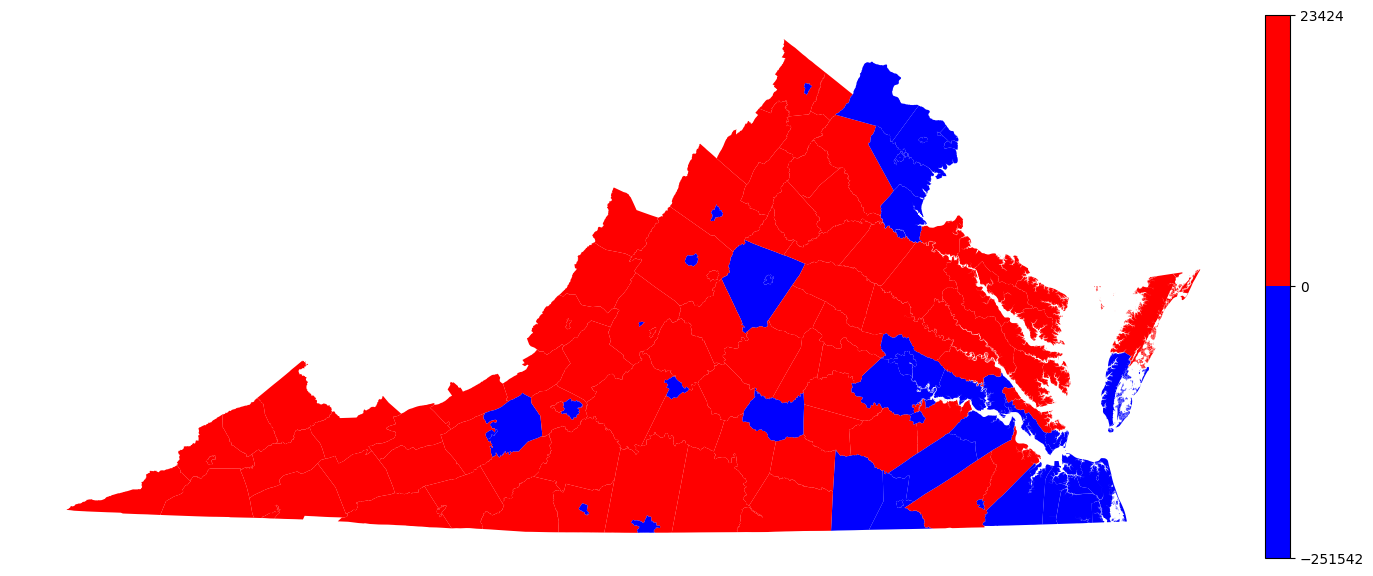

In [ ]:
# Create a custom colormap with red for negative values and blue for positive values
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define the colormap
my_colors = ['blue', 'white', 'red']
my_cmap = ListedColormap(my_colors)

# Define the bins and normalize and force 0 to be part of the colorbar
bounds = [np.min(df['vote_difference_2020']), 0.0, np.max(df['vote_difference_2020'])]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors));

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_difference_2020',legend=True,cax=cax,cmap=my_cmap, norm=my_norm)

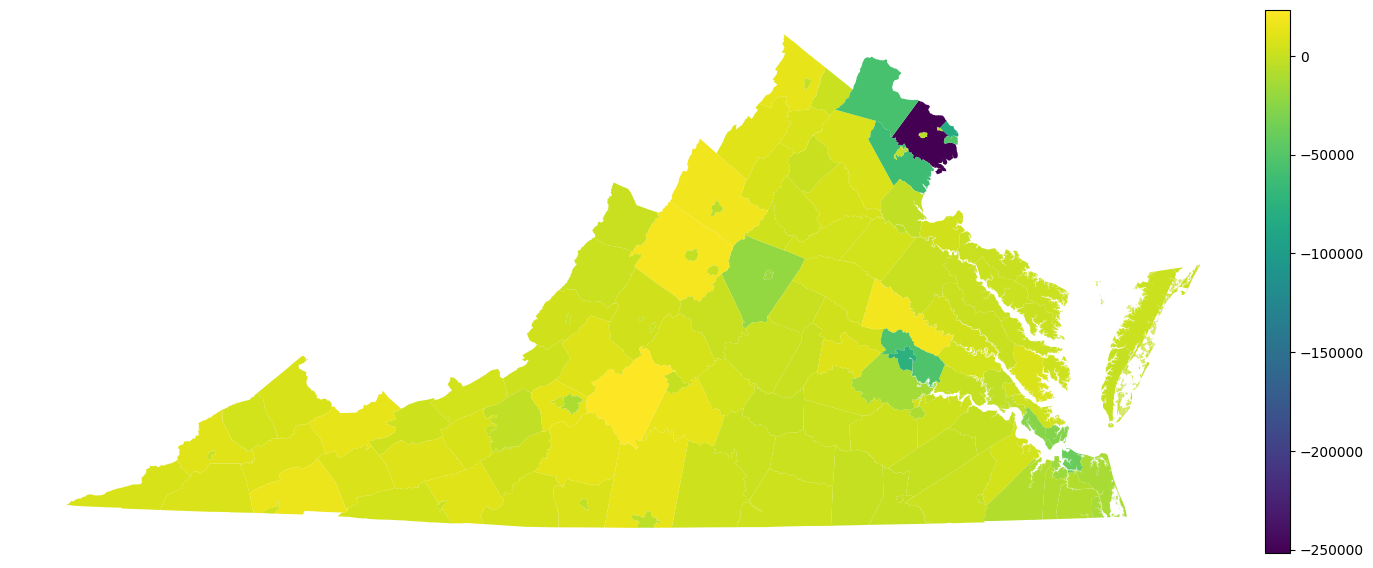

In [ ]:
# Create a custom colormap with red for negative values and blue for positive values

# Plot the heatmap
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)

# Plot the heatmap with the custom colormap
df.plot(ax=ax, column='vote_difference_2020', legend=True, cax=cax)

plt.show()

<Axes: >

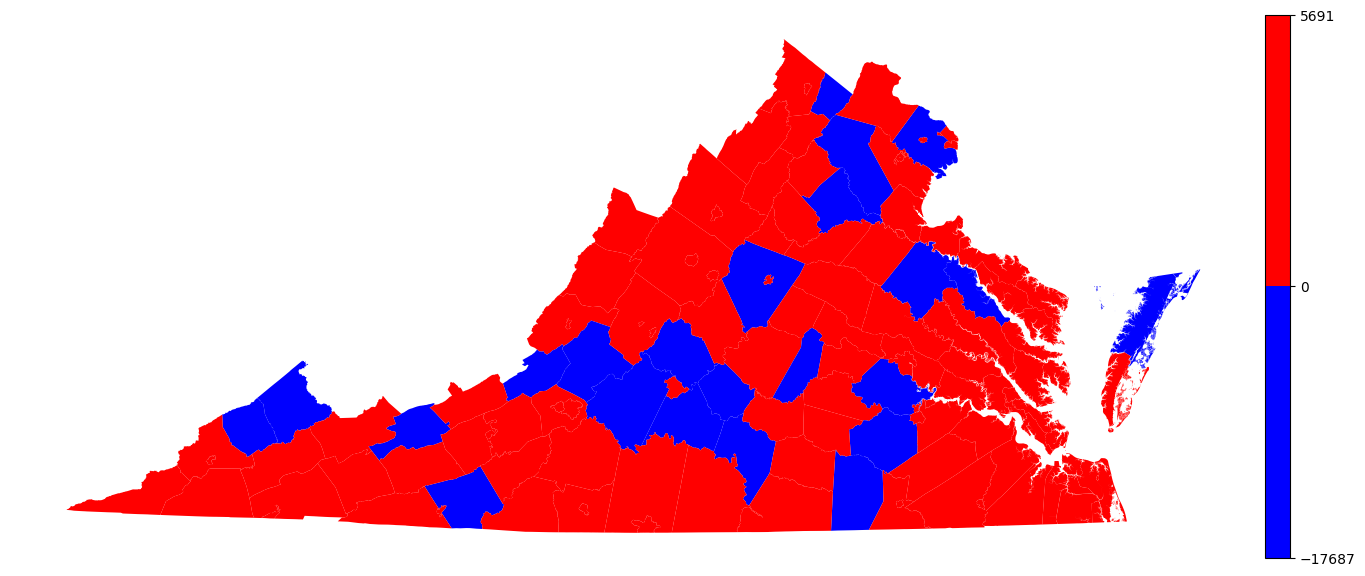

In [ ]:
# Create a custom colormap with red for negative values and blue for positive values
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define the colormap
my_colors = ['blue', 'white', 'red']
my_cmap = ListedColormap(my_colors)

# Define the bins and normalize and force 0 to be part of the colorbar
bounds = [np.min(df['vote_difference_2024']), 0.0, np.max(df['vote_difference_2024'])]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors));

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_difference_2024',legend=True,cax=cax,cmap=my_cmap, norm=my_norm)

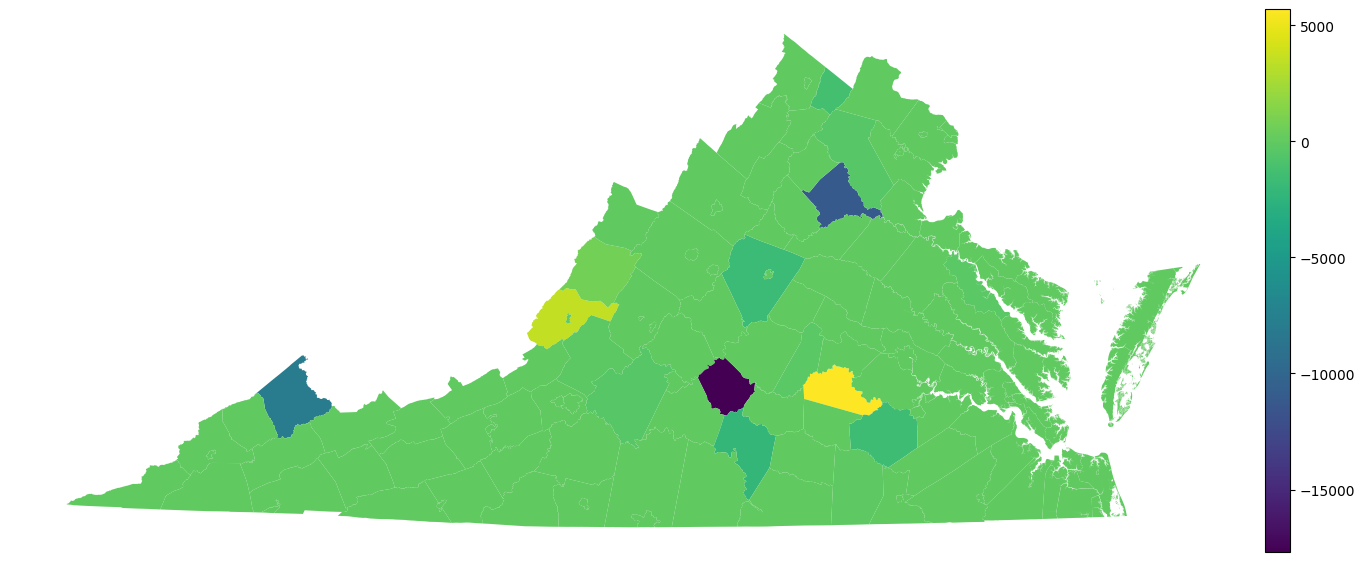

In [ ]:
# Create a custom colormap with red for negative values and blue for positive values

# Plot the heatmap
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)

# Plot the heatmap with the custom colormap
df.plot(ax=ax, column='vote_difference_2024', legend=True, cax=cax)

plt.show()

## Bootstrap

In [64]:
#BOOTSTRAPPING (Elle)
VAcounty_data['vote_difference_2024'] = df['vote_difference_2024']
N = VAcounty_data.shape[0]
#(Elle)
from sklearn.linear_model import LinearRegression # Import linear regression model

VAcounty_data=VAcounty_data.drop(['county'], axis=1)
y = VAcounty_data['county_fips']
X = VAcounty_data.drop('county_fips',axis=1)
reg0 = LinearRegression().fit(X, y) # Fit the linear model
names = reg0.feature_names_in_
coef = pd.DataFrame({'variable':names,'coefficient':reg0.coef_})

print('Intercept: ' + str(reg0.intercept_)+'\n') # Intercept value
print('R2: ' + str(reg0.score(X, y) )) # R squared measure

coef

Intercept: 51081.745084230955

R2: 0.5316740181986886


,variable,coefficient
0,"U.S. citizen, born in the United States",-0.009981
1,"U.S. citizen, born in Puerto Rico or U.S. Isla...",-0.001325
2,"U.S. citizen, born abroad of American parent(s)",0.006819
3,U.S. citizen by naturalization,0.011130
4,Not a U.S. citizen,-0.035646
5,Income in the past 12 months below poverty lev...,-0.024750
6,Income in the past 12 months below poverty lev...,0.068477
7,Income in the past 12 months at or above pover...,-0.013196
8,Income in the past 12 months at or above pover...,0.054123
9,Gini Index,612.329161


In [36]:
#(Elle)
S = 1000
K = len(names)
slopes = np.zeros([S,K])
intercepts = np.zeros(S)
r2s = np.zeros(S)

# Bootstrap:
for s in range(S):
    df_s = VAcounty_data.sample(N,replace=True,axis=0)
    y_s = df_s['county_fips']
    X_s = df_s.drop('county_fips',axis=1)
    #
    reg_s = LinearRegression().fit(X_s, y_s)
    slopes[s,:] = reg_s.coef_.tolist()
    intercepts[s] = reg_s.intercept_
    r2s[s] = reg_s.score(X_s,y_s)

Point Estimate:  0.5634377017786012
CI: [0.45906073 0.66966255]


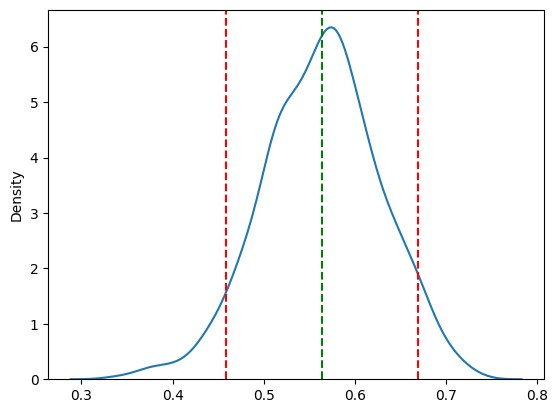

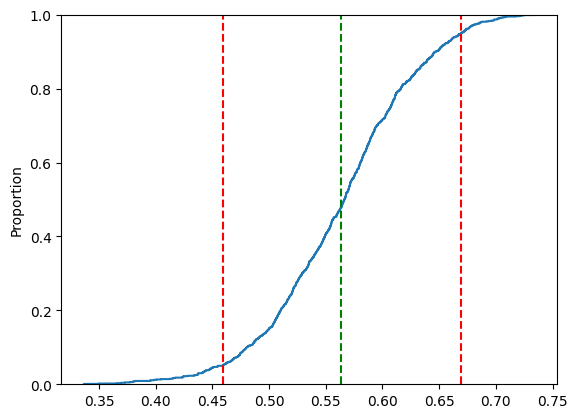

Point Estimate:  51998.964801763934
CI: [50896.91120015 53114.58689221]


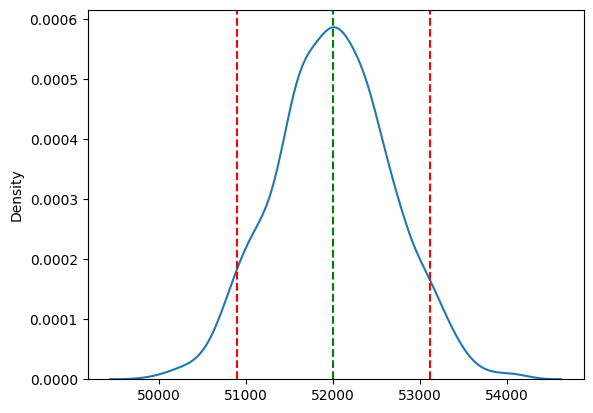

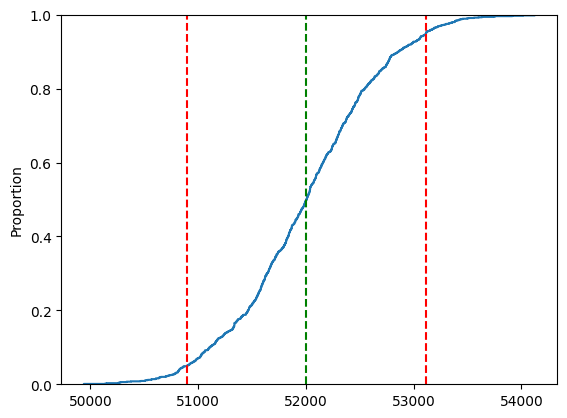

U.S. citizen, born in the United States
Point Estimate:  -297.78348325922315
CI: [-712.66431265  106.97548545]


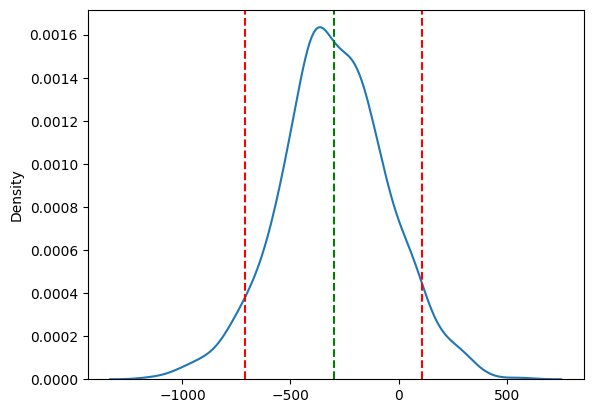

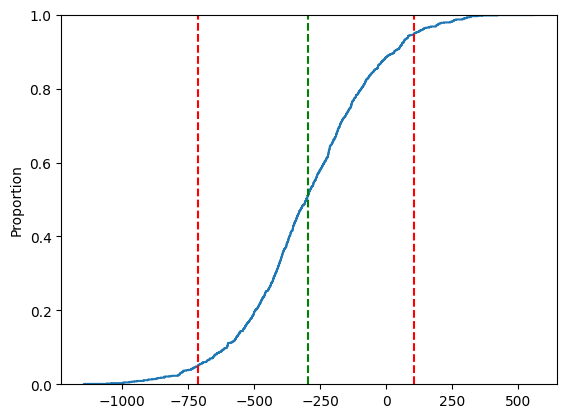

U.S. citizen, born in Puerto Rico or U.S. Island Areas
Point Estimate:  6.359741109618105
CI: [-9.39980432 21.81979611]


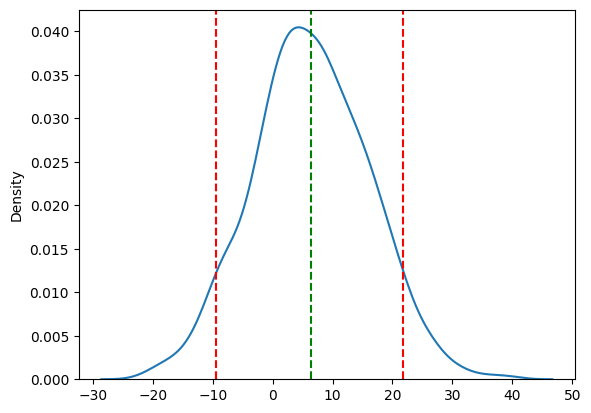

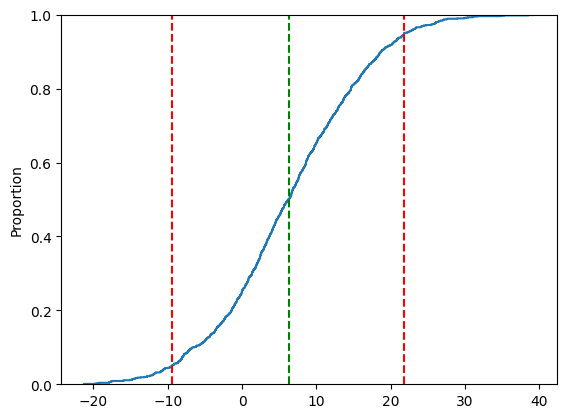

U.S. citizen, born abroad of American parent(s)
Point Estimate:  80.57226980488382
CI: [ 28.47772303 140.20678164]


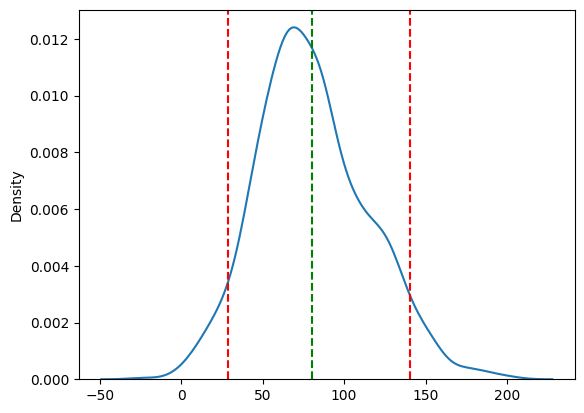

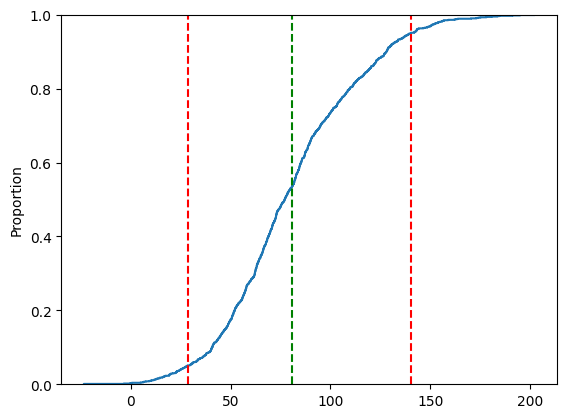

U.S. citizen by naturalization
Point Estimate:  14.861819249751212
CI: [-40.93868724  69.97206575]


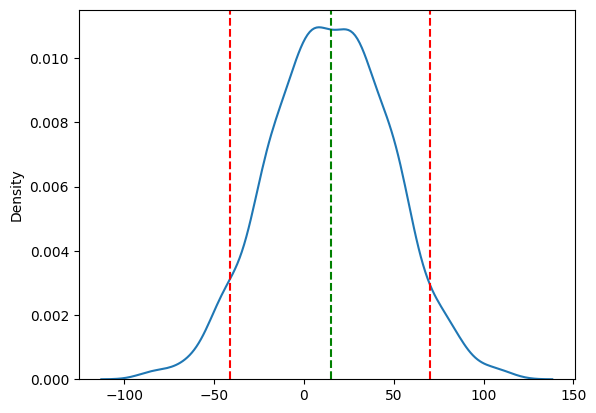

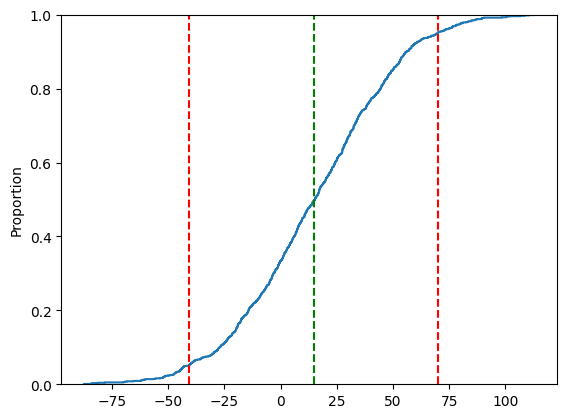

Not a U.S. citizen
Point Estimate:  3.5317371938448883
CI: [-31.6584873   33.60743007]


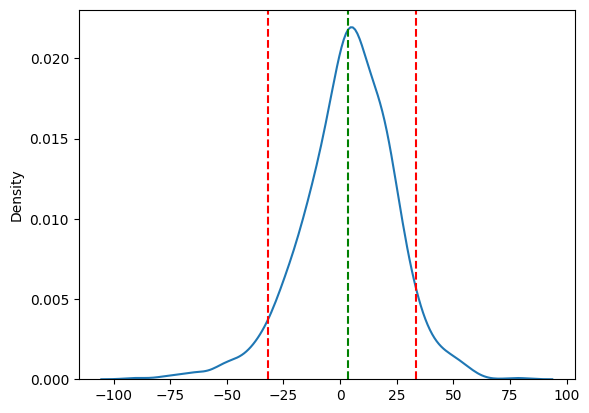

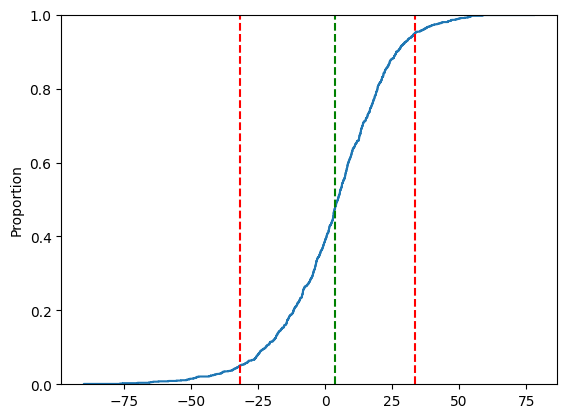

Income in the past 12 months below poverty level: Male
Point Estimate:  39.52030726571873
CI: [-78.80572304 167.65370689]


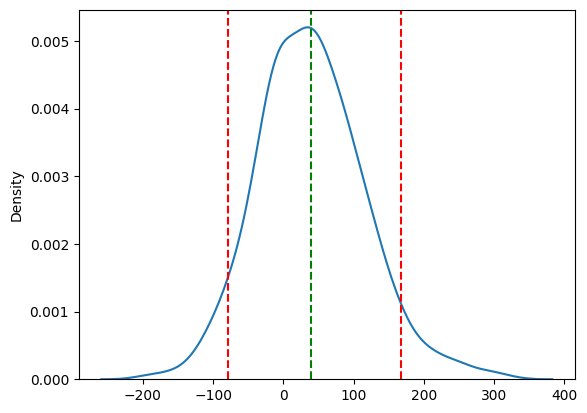

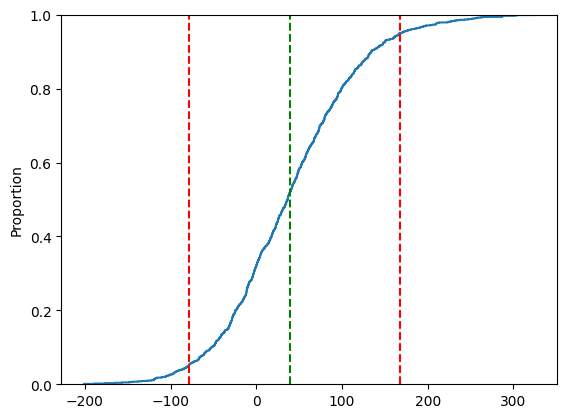

Income in the past 12 months below poverty level: Female
Point Estimate:  107.44915196860829
CI: [-48.23844057 261.63672495]


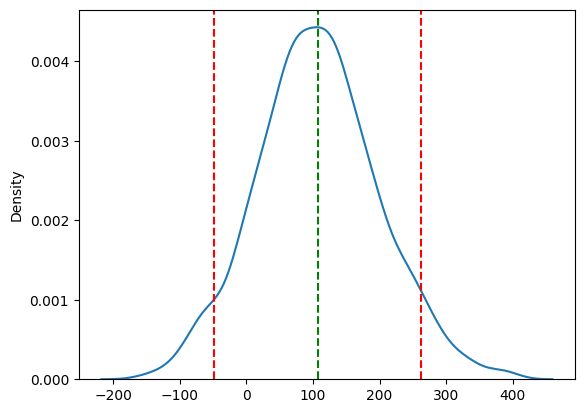

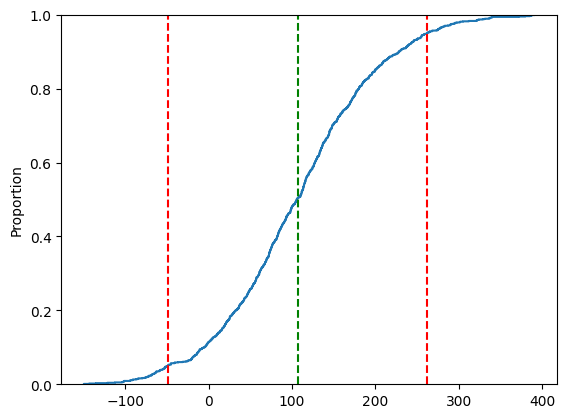

Income in the past 12 months at or above poverty level: Male
Point Estimate:  -934.6208274184088
CI: [-1567.07276306  -366.01032604]


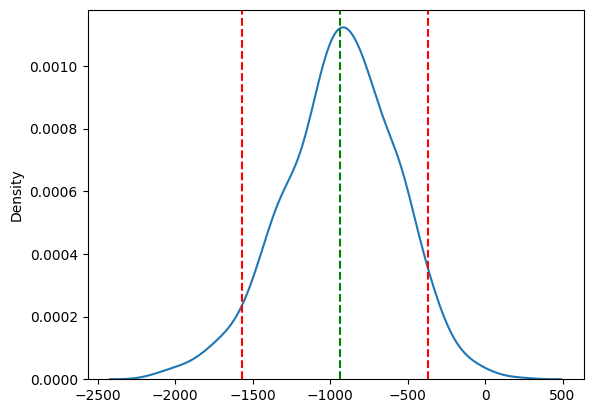

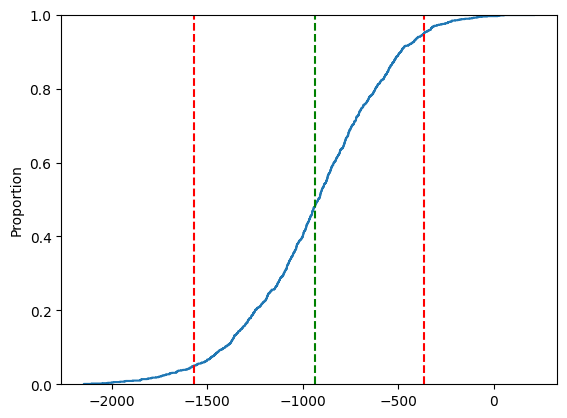

Income in the past 12 months at or above poverty level: Female
Point Estimate:  987.8520627222333
CI: [ 388.74264139 1659.22012621]


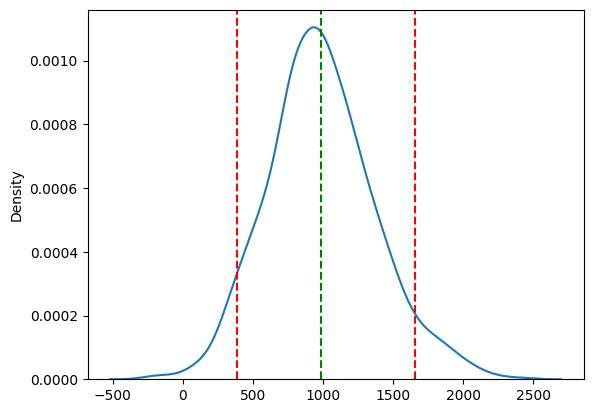

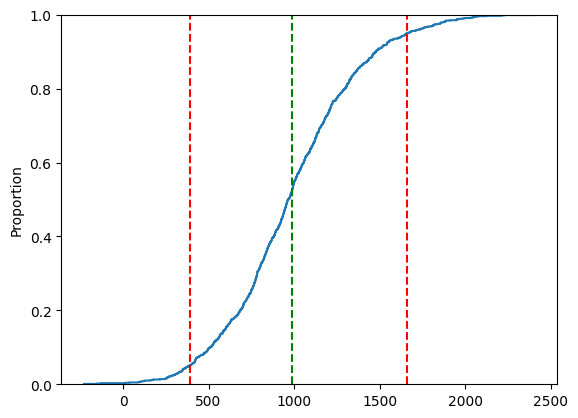

Gini Index
Point Estimate:  391.225158909913
CI: [-458.08402381 1153.21721504]


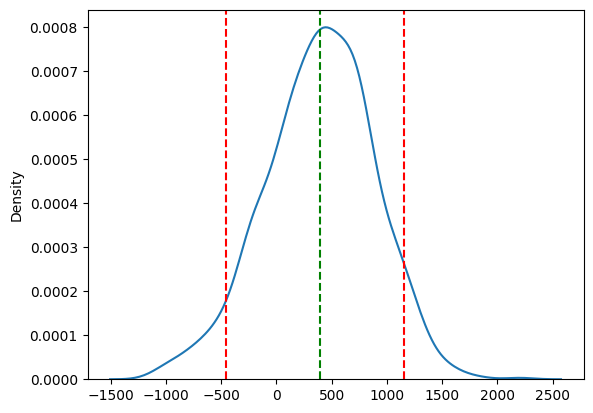

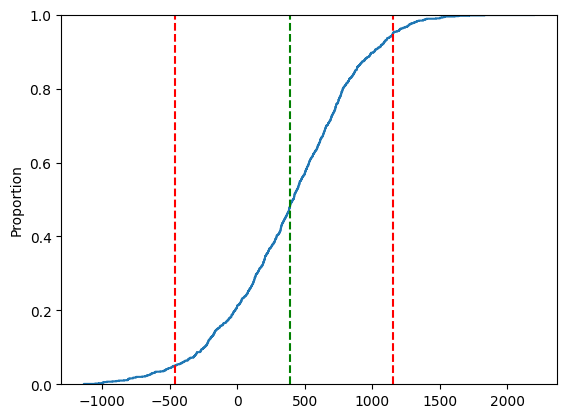

dem_votes_2020
Point Estimate:  -0.00201414513579361
CI: [-0.00539259  0.00077765]


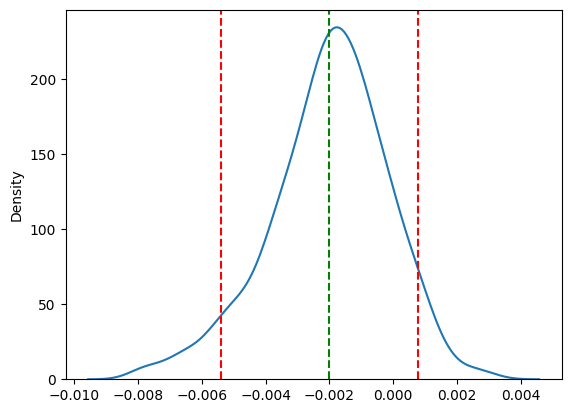

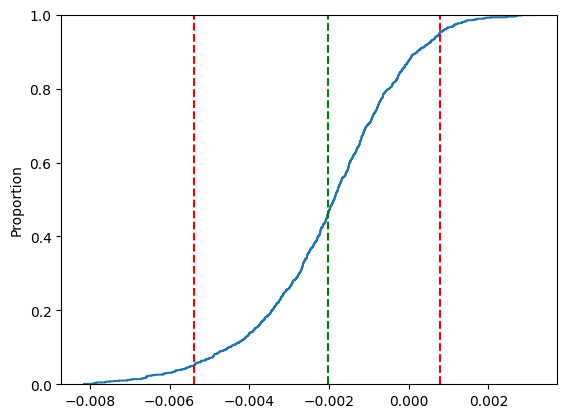

rep_votes_2020
Point Estimate:  -0.00017362149943055358
CI: [-0.00685893  0.0056423 ]


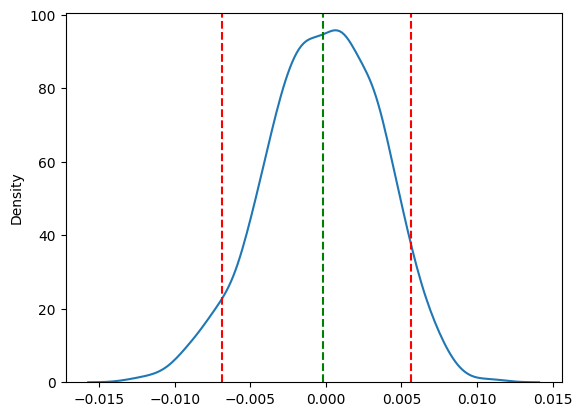

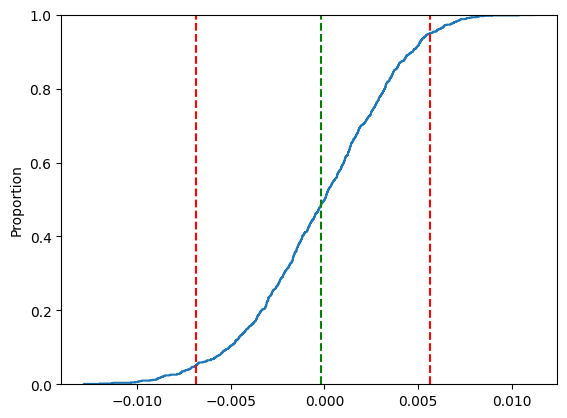

net_vote_count
Point Estimate:  -12.689383482951488
CI: [-19.11448029  -6.5804223 ]


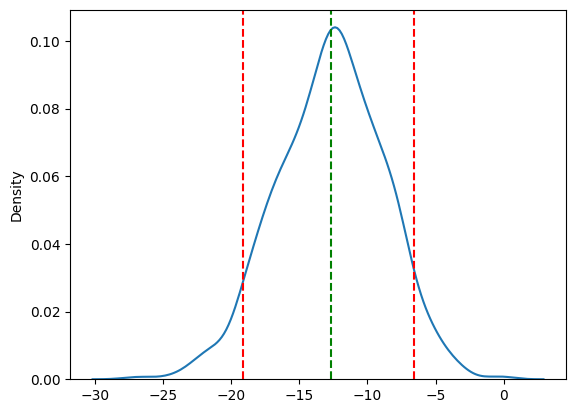

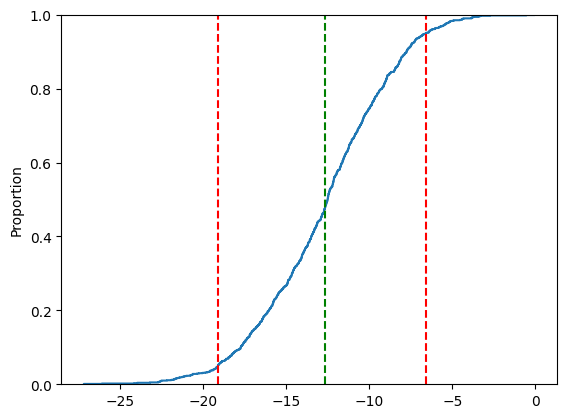

vote_difference_2024
Point Estimate:  0.009751772686017032
CI: [-0.00238053  0.02681546]


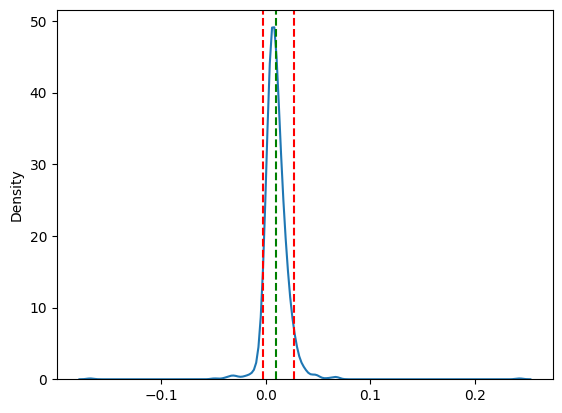

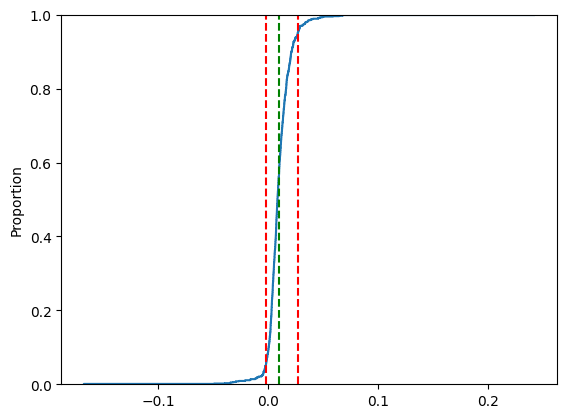

In [37]:
#(Elle)
def CI_eval(var): # Uncertainty analysis for var
    CI = np.quantile(var,[.05,.95]) # Compute 90% CI
    print('Point Estimate: ', var.mean())
    print( 'CI: ' + str(CI) )
    # Density plot of differences in rates, CI:
    ax = sns.kdeplot(var)
    ax.axvline(x = var.mean(),linestyle='dashed',color='green') # Point estimate
    ax.axvline(x = CI[0],linestyle='dashed',color='red') # Lower bound
    ax.axvline(x = CI[1],linestyle='dashed',color='red') # Upper bound
    plt.show()
    # ECDF of differences in rates, CI:
    ax = sns.ecdfplot(var)
    ax.axvline(x = var.mean(),linestyle='dashed',color='green') # Point estimate
    ax.axvline(x = CI[0],linestyle='dashed',color='red') # Lower bound
    ax.axvline(x = CI[1],linestyle='dashed',color='red') # Upper bound
    plt.show()

CI_eval(r2s)
CI_eval(intercepts)

for k in range(K):
    print(names[k])
    CI_eval(slopes[:,k])